In [22]:
# === Imports ====
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torchvision
import timm
import torch.nn.functional as F
from torchvision import transforms
from PIL import Image
from transformers import AutoFeatureExtractor, AutoModel

sns.set(style='whitegrid')

In [23]:
#root_dir ="/kaggle/input/animal-clef-2025"
#metadata_path = "/kaggle/input/animal-clef-2025/metadata.csv"

root_dir = "/Users/matthewjones2/Library/Mobile Documents/com~apple~CloudDocs/UTK Graduate/3. Spring 2025/3.) COSC 574 comp vision/FinalProj/animal-clef-2025_data/"
metadata_path = "/Users/matthewjones2/Library/Mobile Documents/com~apple~CloudDocs/UTK Graduate/3. Spring 2025/3.) COSC 574 comp vision/FinalProj/animal-clef-2025_data/metadata.csv"

# === Visualizing Data ===

In [24]:
metadata_df = pd.read_csv(metadata_path)
metadata_df

,image_id,identity,path,date,orientation,species,split,dataset
0,0,LynxID2025_lynx_37,images/LynxID2025/database/000f9ee1aad063a4485...,NaN,right,lynx,database,LynxID2025
1,1,LynxID2025_lynx_37,images/LynxID2025/database/0020edb6689e9f78462...,NaN,left,lynx,database,LynxID2025
2,2,LynxID2025_lynx_49,images/LynxID2025/database/003152e4145b5b69400...,NaN,left,lynx,database,LynxID2025
3,3,NaN,images/LynxID2025/query/003b89301c7b9f6d18f722...,NaN,back,lynx,query,LynxID2025
4,4,LynxID2025_lynx_13,images/LynxID2025/database/003c3f82011e9c3f849...,NaN,right,lynx,database,LynxID2025
...,...,...,...,...,...,...,...,...
15204,15204,NaN,images/SeaTurtleID2022/query/images/fecd2dfed0...,2024-06-07,NaN,loggerhead turtle,query,SeaTurtleID2022
15205,15205,NaN,images/SeaTurtleID2022/query/images/ff1a0c812b...,2023-06-28,NaN,loggerhead turtle,query,SeaTurtleID2022
15206,15206,NaN,images/SeaTurtleID2022/query/images/ff22f1cfa6...,2024-06-09,NaN,loggerhead turtle,query,SeaTurtleID2022
15207,15207,NaN,images/SeaTurtleID2022/query/images/ff5d5116d1...,2023-06-21,NaN,loggerhead turtle,query,SeaTurtleID2022


In [25]:
# ==== Counting the no of images v/s identity in database

identity_counts = metadata_df[metadata_df['split'] == 'database']['identity'].value_counts().reset_index()
identity_counts.columns = ['identity', 'num_images']
identity_counts

,identity,num_images
0,LynxID2025_lynx_49,353
1,LynxID2025_lynx_62,289
2,LynxID2025_lynx_32,256
3,LynxID2025_lynx_43,234
4,SeaTurtleID2022_t243,190
...,...,...
1097,SalamanderID2025_64,1
1098,SalamanderID2025_65,1
1099,SalamanderID2025_646,1
1100,SalamanderID2025_647,1


# === Exploratory Data Analysis ====

In [26]:
metadata_df.isna().sum()

image_id          0
identity       2135
path              0
date           3907
orientation     703
species        1388
split             0
dataset           0
dtype: int64

In [27]:
metadata_df[metadata_df["split"] == "database"].isna().sum()


image_id          0
identity          0
path              0
date           2961
orientation     203
species        1388
split             0
dataset           0
dtype: int64

In [28]:
metadata_df[metadata_df["split"] == "query"].isna().sum()

image_id          0
identity       2135
path              0
date            946
orientation     500
species           0
split             0
dataset           0
dtype: int64

<Figure size 1200x600 with 0 Axes>

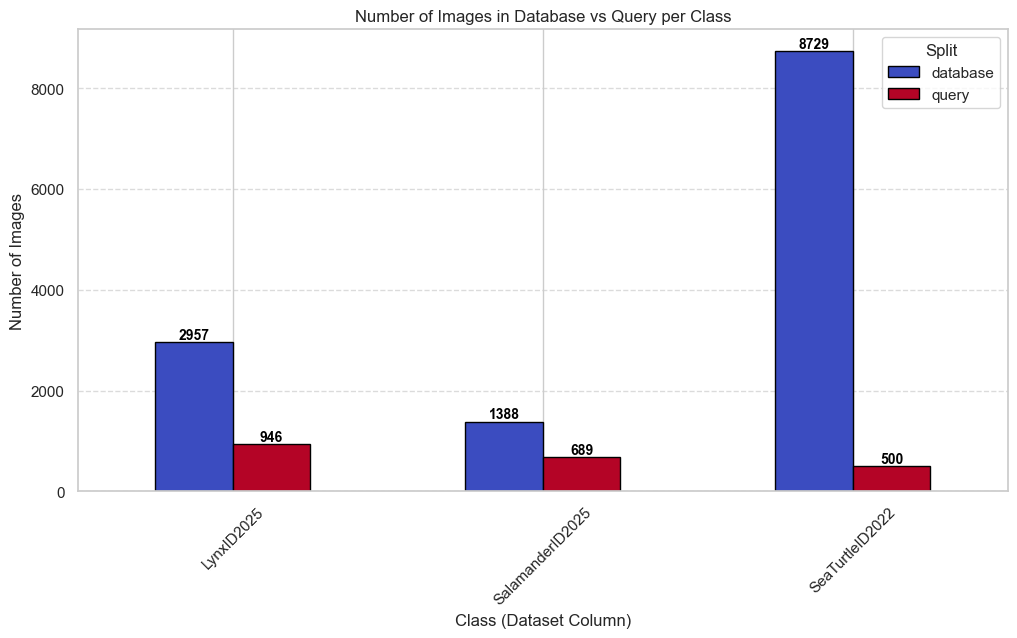

In [29]:
# Count images per class and split
class_distribution = metadata_df.groupby(["dataset", "split"]).size().unstack(fill_value=0)

# Plot
plt.figure(figsize=(12, 6))
ax = class_distribution.plot(kind="bar", colormap="coolwarm", figsize=(12, 6), edgecolor="black")

# Add value labels on bars
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2, p.get_height()),  
                ha='center', va='bottom', fontsize=10, fontweight='bold', color='black')

# Labels and title
plt.xlabel("Class (Dataset Column)")
plt.ylabel("Number of Images")
plt.title("Number of Images in Database vs Query per Class")
plt.legend(title="Split")
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Show plot
plt.show()

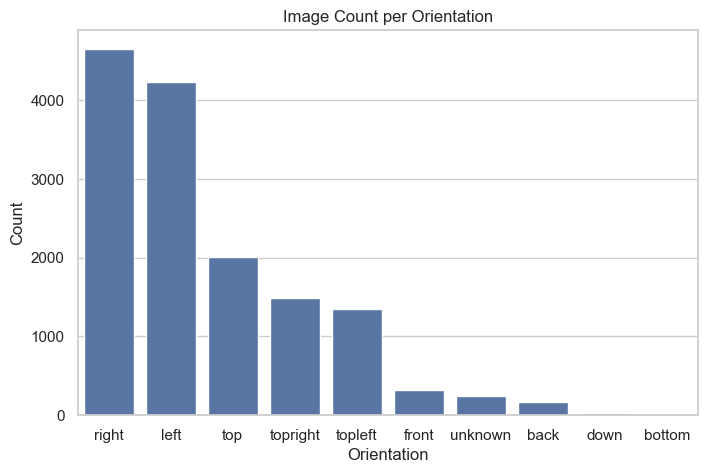

In [30]:
# Visualizing the count of images v/s orientation

plt.figure(figsize=(8, 5))
sns.countplot(data=metadata_df, x="orientation", order=metadata_df["orientation"].value_counts().index)
plt.xlabel("Orientation")
plt.ylabel("Count")
plt.title("Image Count per Orientation")
plt.show()

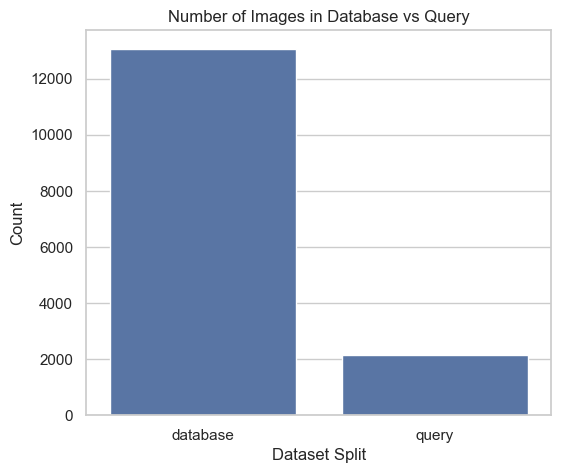

In [31]:
# Visualizing no of images in database v/s query

plt.figure(figsize=(6, 5))
sns.countplot(data=metadata_df, x="split")
plt.xlabel("Dataset Split")
plt.ylabel("Count")
plt.title("Number of Images in Database vs Query")
plt.show()


# == Loading Pretrained Model for Embeddings ==

In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [32]:
# Set device, Mac, GPU, or CPU
if torch.backends.mps.is_available() and torch.backends.mps.is_built():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print("Using device:", device)

Using device: mps


In [33]:
# ==== Loading model and transformations ====
model = timm.create_model("hf-hub:BVRA/MegaDescriptor-L-384", pretrained=True)
model = model.to(device)
model = model.eval()

transform = transforms.Compose([
    transforms.Resize(size=(384, 384)),
    transforms.ToTensor(), 
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

In [34]:
# === Function to extract embeddings ===
def extract_embedding(image_path):
    image = Image.open(image_path).convert("RGB")
    image_tensor = transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(image_tensor)

    # Normalize embedding
    embedding = F.normalize(output, p=2, dim=1).squeeze(0)
    return embedding

In [35]:
# === Looping over database and storing embeddings and metadata
database_embeddings = []

for _, row in metadata_df.iterrows():
    if row["split"] == "database":
        img_path = os.path.join(root_dir, row["path"])
        embed = extract_embedding(img_path)
        # print(len(embed))
        # break

        database_embeddings.append({
            "embedding" : embed,
            "identity" : row["identity"],
            "orientation" : row["orientation"]
        })

In [36]:
len(database_embeddings)

13074

In [37]:
# identifying similar patterns in query images 

threshold = 0.68
query_results = []
for _, row in metadata_df.iterrows():
    if row["split"] == "query":
        img_path = os.path.join(root_dir, row["path"])
        query_embed = extract_embedding(img_path)
        query_orientation = row["orientation"]

        if pd.isna(query_orientation):
            filtered_embeddings = database_embeddings
        else:
            filtered_embeddings = [
                e for e in database_embeddings if e["orientation"] == query_orientation
            ]
            if not filtered_embeddings:
                filtered_embeddings = database_embeddings

        if not filtered_embeddings:
            query_results.append([row["image_id"], "new_individual"])
            continue

        embed_matrix = torch.stack([e["embedding"] for e in filtered_embeddings]).to(device)
        img_identities = [e["identity"] for e in filtered_embeddings]

        # compute similarity scores
        similarity_scores = torch.nn.functional.cosine_similarity(query_embed.unsqueeze(0), embed_matrix, dim=1)
        best_indx = torch.argmax(similarity_scores)

        print(f"Image: {row['path']} | Best Similarity: {similarity_scores[best_indx].item():.4f}")

        if similarity_scores[best_indx].item() > threshold:
            query_results.append([row["image_id"], img_identities[best_indx]])
        else:
            query_results.append([row["image_id"], "new_individual"])

Image: images/LynxID2025/query/003b89301c7b9f6d18f722082617f65f6d5986c9032b660cc02a0735d5bdd0f7.jpg | Best Similarity: 0.5421
Image: images/LynxID2025/query/004d500301a70ec9b5ba08de8ccc6703f08150721af1126e17607ac9218f043b.jpg | Best Similarity: 0.6010
Image: images/LynxID2025/query/00d97c67f0cb0d13a3a449fc4c0ad7d593928d20dbf27b0502fd0f239a3f8548.jpg | Best Similarity: 0.5985
Image: images/LynxID2025/query/00dcbabf03826937bcf6a0a5bedd990ccf716f704f647d454e1b2ab6915334f7.jpg | Best Similarity: 0.7516
Image: images/LynxID2025/query/011d81e0402d1be66bccab7d77796f080368f8c621ded67554a8294543e84183.jpg | Best Similarity: 0.6132
Image: images/LynxID2025/query/0144aa5671e1c06afcafb5fd87788799721ff5954d3c69fa248b2ff034fdeeea.jpg | Best Similarity: 0.1743
Image: images/LynxID2025/query/01bae849a04b09a0653c72c3809aaffebda3d999f6a5c6ba03201ef0ae3a0152.jpg | Best Similarity: 0.5268
Image: images/LynxID2025/query/021516ab05994fe8bb0dc4ae444b8ab9a0c7f323a08be6a579064819cd1bc108.jpg | Best Similarity:

In [38]:
output_df = pd.DataFrame(query_results, columns=['image_id', 'identity'])
output_df

,image_id,identity
0,3,new_individual
1,5,new_individual
2,12,new_individual
3,13,LynxID2025_lynx_05
4,18,new_individual
...,...,...
2130,15204,new_individual
2131,15205,new_individual
2132,15206,SeaTurtleID2022_t202
2133,15207,new_individual


In [39]:
output_df.to_csv("Mega_Descriptor_OutputBase.csv")